In [65]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# import about model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [119]:
# heart_2020
heart_2020_cleaned = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2020/heart_2020_cleaned.csv')

# heart_2022
heart_2022 = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2022/heart_2022_no_nans.csv')

# # heart
# heart = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/heart.csv')

heart_2020_cleaned = heart_2020_cleaned.rename(columns={"HeartDisease":"output"})
heart_2022 = heart_2022.rename(columns={"HadHeartAttack":"output"})

In [120]:
def create_pipeline(X):
    # Determine feature types
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    categorical_features.remove('output')
    categorical_features.remove('AgeCategory')
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


    # Preprocessor for numeric and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),  # Scaling numeric features
            ('cat', OneHotEncoder(drop='first'), categorical_features),  # One-hot encoding categorical features and dropping first column
        ]
    )
    
    # Fit and transform the data
    X_transformed = preprocessor.fit_transform(X)
    print(type(X_transformed))
    if not isinstance(X_transformed, np.ndarray):
        X_transformed = X_transformed.toarray()
    
    # Generate new column names for one-hot encoded features
    encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(encoded_categorical_features)

    # Convert transformed data to DataFrame
    X_transformed = pd.DataFrame(X_transformed, columns=all_feature_names)
    
    # Concatenate 'output' column back to the transformed DataFrame
    X_transformed = pd.concat([X_transformed, X["output"].reset_index(drop=True)], axis=1)
    X_transformed = pd.concat([X_transformed, X["AgeCategory"].reset_index(drop=True)], axis=1)

    return X_transformed

heart_2020_copy = heart_2020_cleaned.copy()
heart_2020_pre = create_pipeline(heart_2020_copy)
print("heart_2020_pre:", heart_2020_pre.head())

heart_2022_copy = heart_2022.copy()
heart_2022_pre = create_pipeline(heart_2022_copy)
print("heart_2022_pro:", heart_2022_pre.head())

<class 'numpy.ndarray'>
heart_2020_pre:         BMI  PhysicalHealth  MentalHealth  SleepTime  Smoking_Yes  \
0 -1.844750       -0.046751      3.281069  -1.460354          1.0   
1 -1.256338       -0.424070     -0.490039  -0.067601          0.0   
2 -0.274603        2.091388      3.281069   0.628776          1.0   
3 -0.647473       -0.424070     -0.490039  -0.763977          0.0   
4 -0.726138        3.097572     -0.490039   0.628776          0.0   

   AlcoholDrinking_Yes  Stroke_Yes  DiffWalking_Yes  Sex_Male  Race_Asian  \
0                  0.0         0.0              0.0       0.0         0.0   
1                  0.0         1.0              0.0       0.0         0.0   
2                  0.0         0.0              0.0       1.0         0.0   
3                  0.0         0.0              0.0       0.0         0.0   
4                  0.0         0.0              1.0       0.0         0.0   

   ...  PhysicalActivity_Yes  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0 

In [121]:
# original coding on "output" "AgeCategory"
ouput_map = {
    'Yes':1,
    'No':0
}
Age_map_2020 = {
    '18-24':0,
    '25-29':1,
    '30-34':2,
    '35-39':3,
    '40-44':4,
    '45-49':5,
    '50-54':6,
    '55-59':7,
    '60-64':8,
    '65-69':9,
    '70-74':10,
    '75-79':11,
    '80 or older':12    
}

Age_map_2022 = {
    'Age 18 to 24':0,
    'Age 25 to 29':1,
    'Age 30 to 34':2,
    'Age 35 to 39':3,
    'Age 40 to 44':4,
    'Age 45 to 49':5,
    'Age 50 to 54':6,
    'Age 55 to 59':7,
    'Age 60 to 64':8,
    'Age 65 to 69':9,
    'Age 70 to 74':10,
    'Age 75 to 79':11,
    'Age 80 or older':12    
}


heart_2020_pre['output1'] = heart_2020_pre['output'].map(ouput_map)
heart_2020_pre['AgeCategory'] = heart_2020_pre['AgeCategory'].map(Age_map_2020)
heart_2020_pre = heart_2020_pre.drop(columns='output') 
heart_2020_pre = heart_2020_pre.rename(columns={"output1":"output"})
print(heart_2020_pre.head)

heart_2022_pre['output1'] = heart_2022_pre['output'].map(ouput_map)
heart_2022_pre['AgeCategory'] = heart_2022_pre['AgeCategory'].map(Age_map_2022)
heart_2022_pre = heart_2022_pre.drop(columns='output') 
heart_2022_pre = heart_2022_pre.rename(columns={"output1":"output"})
print(heart_2022_pre.head)

<bound method NDFrame.head of              BMI  PhysicalHealth  MentalHealth  SleepTime  Smoking_Yes  \
0      -1.844750       -0.046751      3.281069  -1.460354          1.0   
1      -1.256338       -0.424070     -0.490039  -0.067601          0.0   
2      -0.274603        2.091388      3.281069   0.628776          1.0   
3      -0.647473       -0.424070     -0.490039  -0.763977          0.0   
4      -0.726138        3.097572     -0.490039   0.628776          0.0   
...          ...             ...           ...        ...          ...   
319790 -0.144019        0.456341     -0.490039  -0.763977          1.0   
319791  0.238291       -0.424070     -0.490039  -1.460354          1.0   
319792 -0.642753       -0.424070     -0.490039  -0.763977          0.0   
319793  0.705560       -0.424070     -0.490039   3.414282          0.0   
319794  2.868839       -0.424070     -0.490039   0.628776          0.0   

        AlcoholDrinking_Yes  Stroke_Yes  DiffWalking_Yes  Sex_Male  \
0          

In [122]:

def over_sampling(X, random_state=42):
    """
    Oversamples the minority class in the 'output' column to balance the classes.
    
    Parameters:
    X (DataFrame): The dataset containing the 'output' column.
    random_state (int): Seed used by the random number generator.
    
    Returns:
    X_resampled (DataFrame): Resampled dataset with balanced classes in the 'output' column.
    """
    np.random.seed(random_state)
    
    # Ensure 'output' column is present
    if 'output' not in X.columns:
        raise ValueError("The dataset must contain an 'output' column.")
    
    # Separate the majority and minority classes
    class_counts = X['output'].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    X_majority = X[X['output'] == majority_class]
    X_minority = X[X['output'] == minority_class]
    
    # Calculate the number of samples to add to the minority class
    n_majority = len(X_majority)
    n_minority = len(X_minority)
    n_to_add = n_majority - n_minority
 
    indices_to_add = np.random.choice(X_minority.index, size=n_to_add, replace=True)
    X_oversampled = X_minority.loc[indices_to_add]
    X_resampled = pd.concat([X_majority, X_minority, X_oversampled])

    X_resampled = X_resampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return X_resampled

Original heart_2020 shape: (319795, 27)
Original 'output' class distribution:
output
0    292422
1     27373
Name: count, dtype: int64
Resampled heart_2020 shape: (584844, 27)
Resampled 'output' class distribution:
output
1    292422
0    292422
Name: count, dtype: int64


In [123]:
# resampling of heart_2020_pre and heart_2022_pre
# 2020
print("Original heart_2020 shape:", heart_2020_pre.shape) 
print("Original 'output' class distribution:")
print(heart_2020_pre['output'].value_counts())

heart_2020_resampled = over_sampling(heart_2020_pre)

print("Resampled heart_2020 shape:", heart_2020_resampled.shape)
print("Resampled 'output' class distribution:")
print(heart_2020_resampled['output'].value_counts())

# 2022
print("Original heart_2022 shape:", heart_2022_pre.shape) 
print("Original 'output' class distribution:")
print(heart_2022_pre['output'].value_counts())

heart_2022_resampled = over_sampling(heart_2022_pre)

print("Resampled heart_2022 shape:", heart_2022_resampled.shape)
print("Resampled 'output' class distribution:")
print(heart_2022_resampled['output'].value_counts())

Original heart_2020 shape: (319795, 27)
Original 'output' class distribution:
output
0    292422
1     27373
Name: count, dtype: int64
Resampled heart_2020 shape: (584844, 27)
Resampled 'output' class distribution:
output
1    292422
0    292422
Name: count, dtype: int64
Original heart_2022 shape: (246022, 111)
Original 'output' class distribution:
output
0    232587
1     13435
Name: count, dtype: int64
Resampled heart_2022 shape: (465174, 111)
Resampled 'output' class distribution:
output
0    232587
1    232587
Name: count, dtype: int64


In [124]:
# split X_train and y_train
X_2020 = heart_2020_resampled.drop(columns='output')  # type: ignore
y_2020 = heart_2020_resampled['output']  # type: ignore

X_2022 = heart_2022_resampled.drop(columns='output')  # type: ignore
y_2022 = heart_2022_resampled['output']  # type: ignore

In [126]:
# train and validate model in two datasets apparently -choose the best one
def train_validate_model(n_splits, X_train, y_train, model_name, grid_in=None):
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=45).split(X_train, y_train)
    
    rmse_list = []
    # Initialize an empty DataFrame to store feature importances
    feature_importance_all_folds = pd.DataFrame(columns=X_train.columns)
    
    for train_idx, val_idx in folds:
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        if model_name == 'random forest':
            # 使用GridSearchCV找到最佳参数
            # 如果grid_in不是None，启用GridSearchCV
            if grid_in:
                clf = GridSearchCV(RandomForestRegressor(random_state=123), grid_in)
                clf.fit(X_tr, y_tr)
                mod = RandomForestRegressor(**clf.best_params_, random_state=123)
                print("Best perf", clf.best_score_, "Best params", clf.best_params_)
            else:
                mod = RandomForestRegressor(random_state=123)
                
        elif model_name == 'decision tree':
            mod = DecisionTreeRegressor(random_state=45)
        elif model_name == 'logistic regression':
            mod = LogisticRegression(random_state=45, max_iter=1000)
        elif model_name == 'XGBoost':
            mod = XGBRegressor(random_state=45)
        elif model_name == 'Gradient Boosting':
            mod = GradientBoostingRegressor(random_state=45)
        elif model_name == 'AdaBoost':
            mod = AdaBoostRegressor(random_state=45)
        elif model_name == 'CatBoost':
            mod = CatBoostRegressor(random_state=45, verbose=0)
        elif model_name == 'Ridge':
            mod = Ridge(random_state=45)
        elif model_name == 'Lasso':
            mod = Lasso(random_state=45)
        else:
            raise ValueError(f"Unknown model name: {model_name}")
            pass

        # 训练模型
        mod.fit(X_tr, y_tr)
        
        # 预测验证集
        y_pred = mod.predict(X_val)
        
        # calculate RMSE
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_list.append(rmse)
        
        # print(f'Fold RMSE: {rmse}')

        # feature importance
        if model_name == 'random forest':
            feature_importances = mod.feature_importances_
            feature_importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': feature_importances
            })
            # Append fold feature importance to the main DataFrame
            feature_importance_all_folds = pd.concat([feature_importance_all_folds, feature_importance_df.set_index('Feature')], axis=1)
    
    if model_name == 'random forest':
        feature_importance_avg = feature_importance_all_folds.mean(axis=1)
        feature_importance_avg = feature_importance_avg.sort_values(ascending=False)
        print("\nAverage Feature Importance Order:")
        print(feature_importance_avg)

        # Plot feature importance using a bar chart with gradient colors
        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance_avg.index, feature_importance_avg.values, color=plt.cm.cividis(np.linspace(0, 1, len(feature_importance_avg))))
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Average Feature Importance across Folds')
        plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
        plt.show()
        
    # loss -rmse
    average_rmse = np.mean(rmse_list)
    print(f'Average RMSE: {average_rmse}')
    
    return average_rmse

def plot_rmse(models, rmses):
    plt.figure(figsize=(12, 6))
    plt.bar(models, rmses, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE for Different Models')
    for i, v in enumerate(rmses):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()

Training and validating random forest model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.


Average Feature Importance Order:
BMI                                 0.280209
AgeCategory                         0.217019
SleepTime                           0.079957
PhysicalHealth                      0.053476
MentalHealth                        0.052964
DiffWalking_Yes                     0.049838
Sex_Male                            0.027525
PhysicalActivity_Yes                0.022128
Stroke_Yes                          0.021991
GenHealth_Fair                      0.021627
GenHealth_Good                      0.018564
SkinCancer_Yes                      0.017246
Smoking_Yes                         0.017019
Asthma_Yes                          0.016995
GenHealth_Poor                      0.016532
Diabetic_Yes                        0.015975
Race_White                          0.011596
AlcoholDrinking_Yes                 0.010338
KidneyDisease_Yes                   0.010052
Race_Black                          0.008059
GenHealth_Very good                 0.007654
Race_Hispanic       

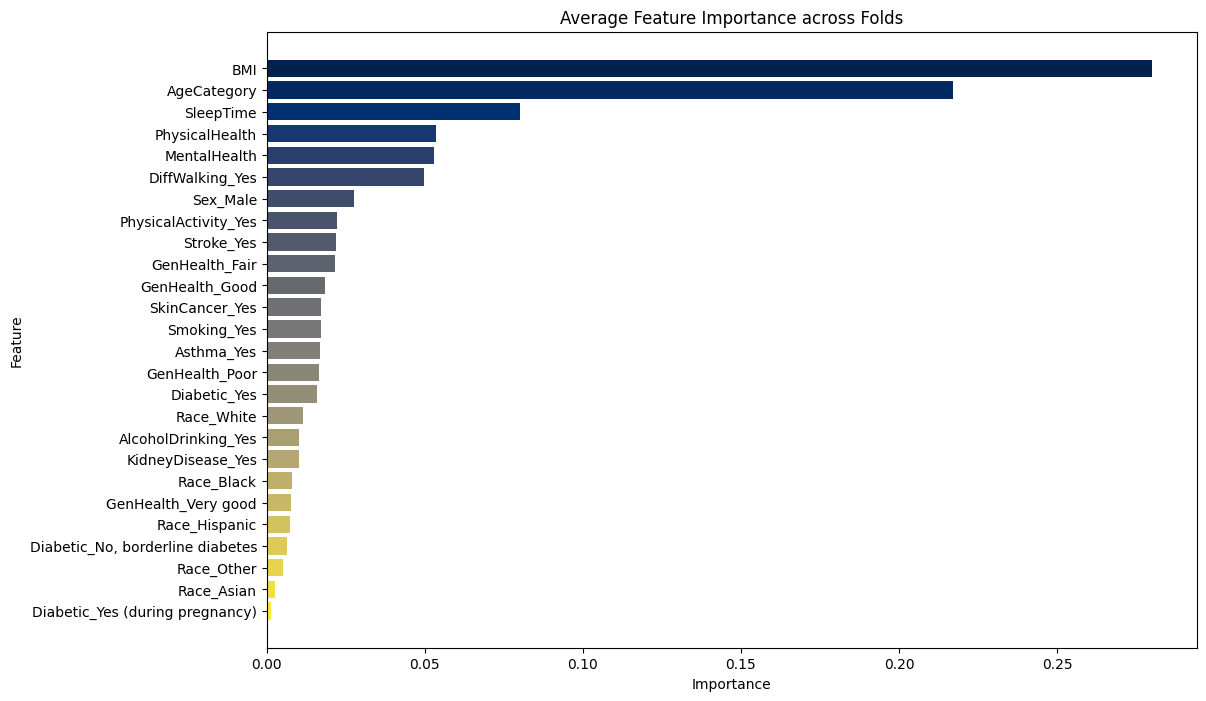

Average RMSE: 0.16636600326668433
Training and validating decision tree model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.20979210154357175
Training and validating logistic regression model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.48581450698360307
Training and validating XGBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.38584287375094456
Training and validating Gradient Boosting model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.401476860217142
Training and validating AdaBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.4310815070417774
Training and validating CatBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.3858939547604533
Training and validating Ridge model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.40785635032329204
Training and validating Lasso model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.5000000000082228


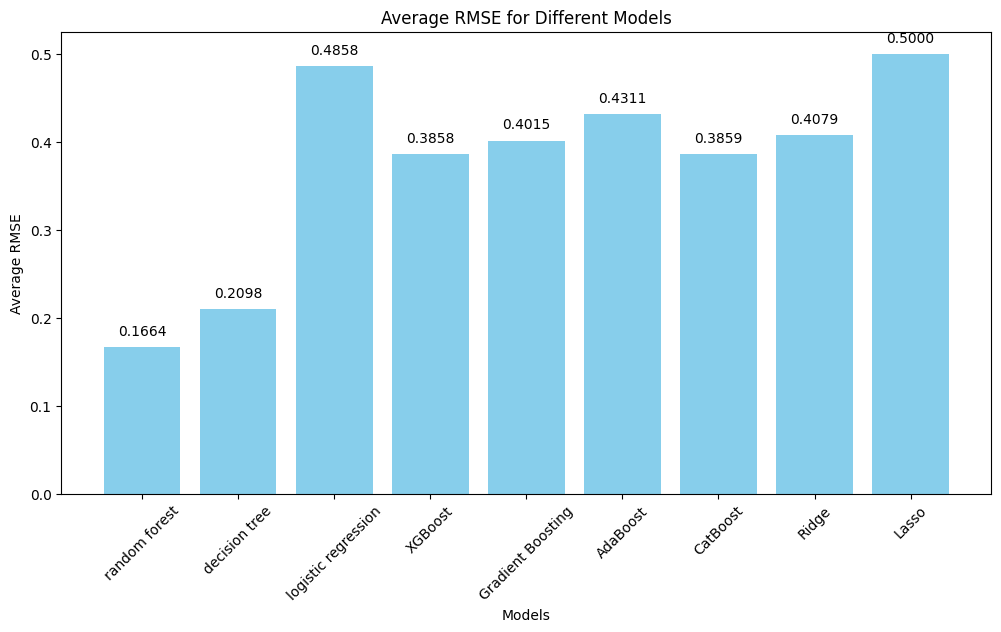

[0.16636600326668433,
 0.20979210154357175,
 0.48581450698360307,
 0.38584287375094456,
 0.401476860217142,
 0.4310815070417774,
 0.3858939547604533,
 0.40785635032329204,
 0.5000000000082228]

In [127]:
# grid_in(don't use because of computational expensive)
# grid_in = {
#     'n_estimators': [100, 200, 300],  # number of trees
#     'max_depth': [10, 20, None],      # maximum depth of trees
#     'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],    # minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt']  
# }

models = ['random forest', 'decision tree', 'logistic regression', 'XGBoost',
          'Gradient Boosting', 'AdaBoost', 'CatBoost', 'Ridge', 'Lasso'] #, 'SVM'

# 2020 heart
def train_validate_plot(models,X_trian,y_trian):
    average_rmses = []
    for model_name in models:
        print(f"Training and validating {model_name} model")
        average_rmse = train_validate_model(n_splits=5, X_train=X_trian, y_train=y_trian, model_name=model_name)
        average_rmses.append(average_rmse)
    plot_rmse(models, average_rmses)
    return average_rmses
train_validate_plot(models=models,X_trian=X_2020,y_trian=y_2020)
    

Training and validating random forest model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.


Average Feature Importance Order:
HadAngina_Yes                                          0.279762
ChestScan_Yes                                          0.067391
AgeCategory                                            0.059765
BMI                                                    0.056887
WeightInKilograms                                      0.044003
                                                         ...   
State_Nevada                                           0.001196
State_Guam                                             0.001051
State_District of Columbia                             0.001029
HadDiabetes_Yes, but only during pregnancy (female)    0.000802
State_Virgin Islands                                   0.000489
Length: 110, dtype: object


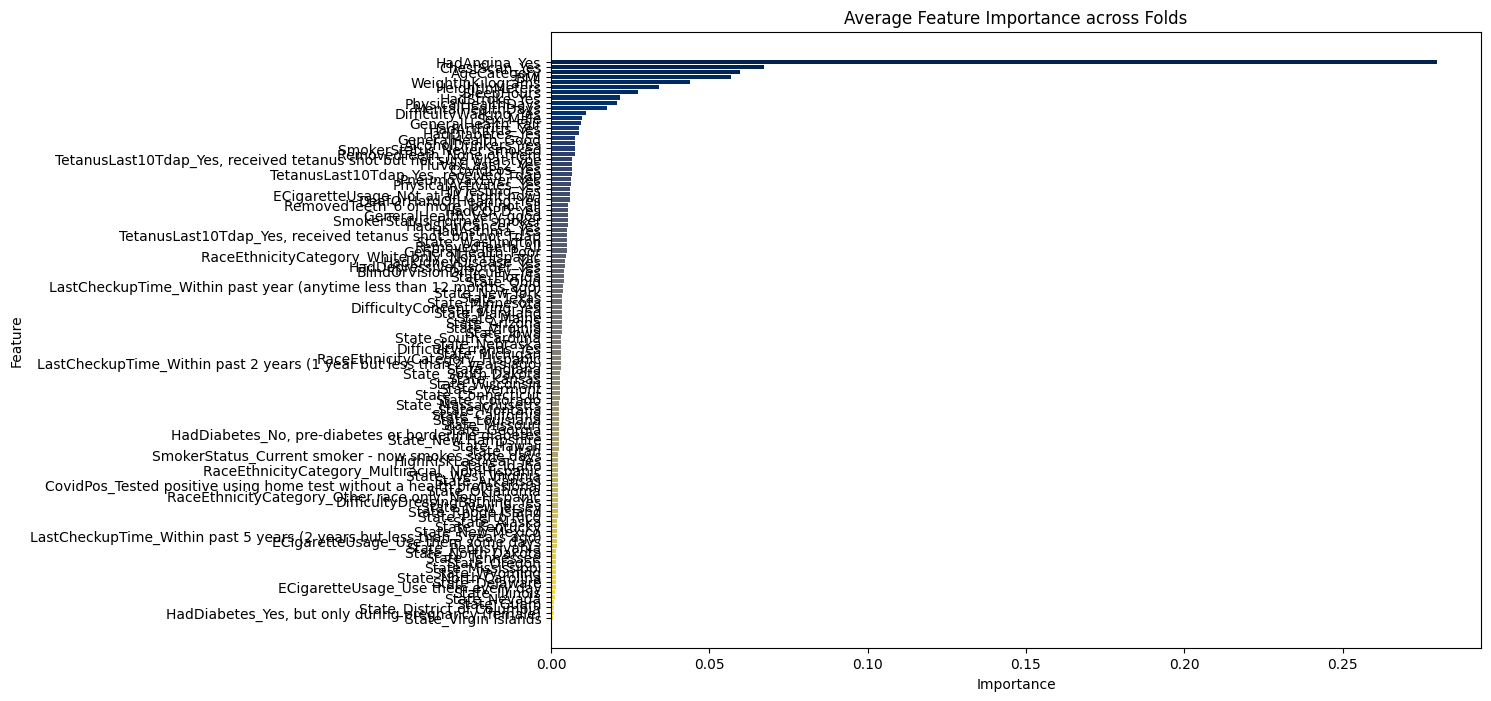

Average RMSE: 0.11407547725086911
Training and validating decision tree model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.17086517001467208
Training and validating logistic regression model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.4433164560688857
Training and validating XGBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.32693641403195234
Training and validating Gradient Boosting model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.36462958206259155
Training and validating AdaBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.39245129613969204
Training and validating CatBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.3251380616746173
Training and validating Ridge model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.37469634040643685
Training and validating Lasso model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

Average RMSE: 0.5000000000129975


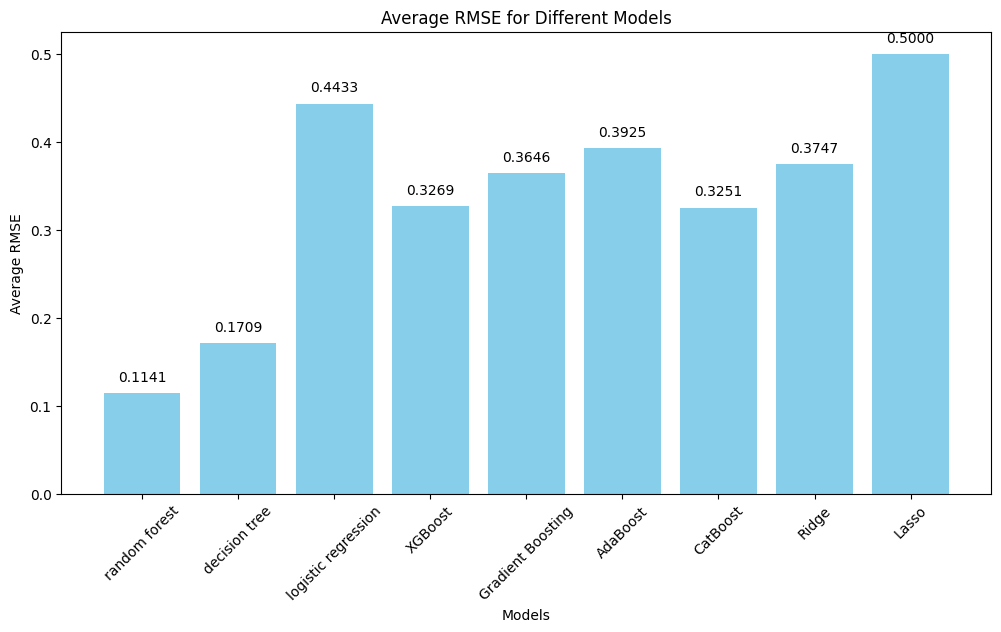

[0.11407547725086911,
 0.17086517001467208,
 0.4433164560688857,
 0.32693641403195234,
 0.36462958206259155,
 0.39245129613969204,
 0.3251380616746173,
 0.37469634040643685,
 0.5000000000129975]

In [128]:
train_validate_plot(models=models,X_trian=X_2022,y_trian=y_2022)


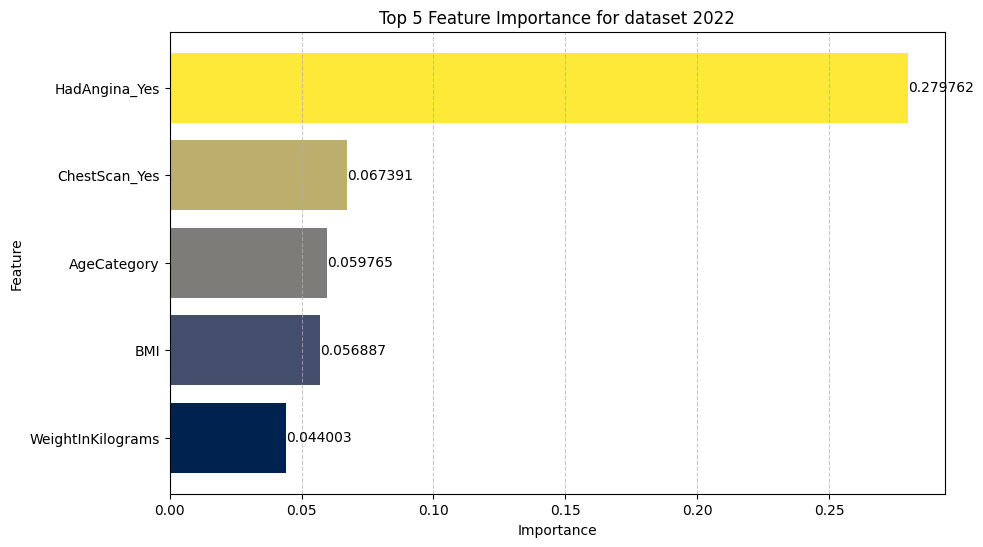

In [136]:

# 特征名称和对应的重要性值
features = ['HadAngina_Yes', 'ChestScan_Yes', 'AgeCategory', 'BMI', 'WeightInKilograms']
importances = [0.279762, 0.067391, 0.059765, 0.056887, 0.044003]

# 创建一个 DataFrame 以便于排序（如果使用 pandas）
import pandas as pd
df = pd.DataFrame({'Feature': features, 'Importance': importances})

# 按照重要性值降序排序
df = df.sort_values(by='Importance', ascending=True)

# 创建水平柱状图
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Feature'], df['Importance'], color=plt.cm.cividis(np.linspace(0, 1, len(df))))

# 在每个柱子上方添加对应的值
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 6),
             ha='left', va='center')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importance for dataset 2022')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # 添加网格线以增强图形可读性

plt.show()


In [63]:
import pickle

# Save X_2020
with open('X_2020.pkl', 'wb') as file:
    pickle.dump(X_2020, file)
    print("success")

# Save y_2020
with open('y_2020.pkl', 'wb') as file:
    pickle.dump(y_2020, file)
    print("success")


success
success


## question
1. unbalanced dataset leading to the poorer performance to "YES", how to solve

raja: 
undersampling 
smote oversampling, make it balanced
meanwhile control the size of three datasets to make them close


3. we need other models, 
4. in previous study, how do they compare the importance of personal behaviors and accurate numbers


5. how to measure the formance of model,
--regression: rmse

question 0807
我有一个想法，不用那个小数据集，直接研究2020和2022的大数据集，研究影响心脏病的因素和影响因素的变化趋势--问问助教



Feature importance order:                                 Feature  Importance
0                                   BMI    0.275639
3                             SleepTime    0.078293
1                        PhysicalHealth    0.052517
2                          MentalHealth    0.051645
35                         Diabetic_Yes    0.045691
11                      DiffWalking_Yes    0.042424
10                       DiffWalking_No    0.042393
26              AgeCategory_80 or older    0.034049
24                    AgeCategory_70-74    0.027162
25                    AgeCategory_75-79    0.024956
23                    AgeCategory_65-69    0.020729
43                  GenHealth_Very good    0.018130
39                  GenHealth_Excellent    0.018095
22                    AgeCategory_60-64    0.015604
13                             Sex_Male    0.014446
12                           Sex_Female    0.012827
37                  PhysicalActivity_No    0.011856
38                 PhysicalActivity_Yes    0.011835
8                             Stroke_No    0.011190
32                           Race_White    0.011017
41                       GenHealth_Good    0.010131
5                           Smoking_Yes    0.009841
4                            Smoking_No    0.009802
9                            Stroke_Yes    0.009756
40                       GenHealth_Fair    0.009195
48                        SkinCancer_No    0.009041
45                           Asthma_Yes    0.009013
44                            Asthma_No    0.008960
49                       SkinCancer_Yes    0.008954
21                    AgeCategory_55-59    0.008938
29                           Race_Black    0.007954
30                        Race_Hispanic    0.007213
20                    AgeCategory_50-54    0.006678
42                       GenHealth_Poor    0.005997
7                   AlcoholDrinking_Yes    0.005378
6                    AlcoholDrinking_No    0.005362
47                    KidneyDisease_Yes    0.005345
46                     KidneyDisease_No    0.005322
31                           Race_Other    0.005045
19                    AgeCategory_45-49    0.004382
33                          Diabetic_No    0.003779
18                    AgeCategory_40-44    0.003709
34     Diabetic_No, borderline diabetes    0.003516
17                    AgeCategory_35-39    0.003410
27  Race_American Indian/Alaskan Native    0.003321
28                           Race_Asian    0.002799
16                    AgeCategory_30-34    0.002542
15                    AgeCategory_25-29    0.001729
14                    AgeCategory_18-24    0.001423
36      Diabetic_Yes (during pregnancy)    0.000965